# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a s3 bucket: `s3://sta9760-yelp-datasets/

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1619312038068_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [2]:
import matplotlib
import pandas
import seaborn

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [13]:
df1 = spark.read.json('s3://sta9760-yelp-datasets/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [5]:
print(f'Columns: {len(df1.dtypes)} | Rows: {df1.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 160,585

Display the DataFrame schema below.

In [6]:
df1.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [14]:
df1.createOrReplaceTempView("business")
sqldf = spark.sql(
'''
SELECT business_id,name,city,state,stars,categories 
FROM business 
'''
)
sqldf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+--------------------+
|         business_id|                name|       city|state|stars|          categories|
+--------------------+--------------------+-----------+-----+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|  4.0|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|  4.0|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|  4.5|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|  3.0|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|  4.0|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [51]:
associationTable = spark.sql(
'''
SELECT business_id,explode(split(categories,', ')) as category 
FROM business
'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
associationTable.createOrReplaceTempView("categories")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [14]:
output = spark.sql('SELECT * FROM categories')
output.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [17]:
uniCat = spark.sql('SELECT DISTINCT category FROM categories')
print(uniCat.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1330

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [20]:
countCat = spark.sql('SELECT category, count(*) as count FROM categories GROUP BY category')
countCat.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [32]:
topCat = spark.sql(
'''SELECT category, count(*) as count 
FROM categories 
GROUP BY category 
ORDER BY count(*) desc
LIMIT 20
'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
topCat_pdf = topCat.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

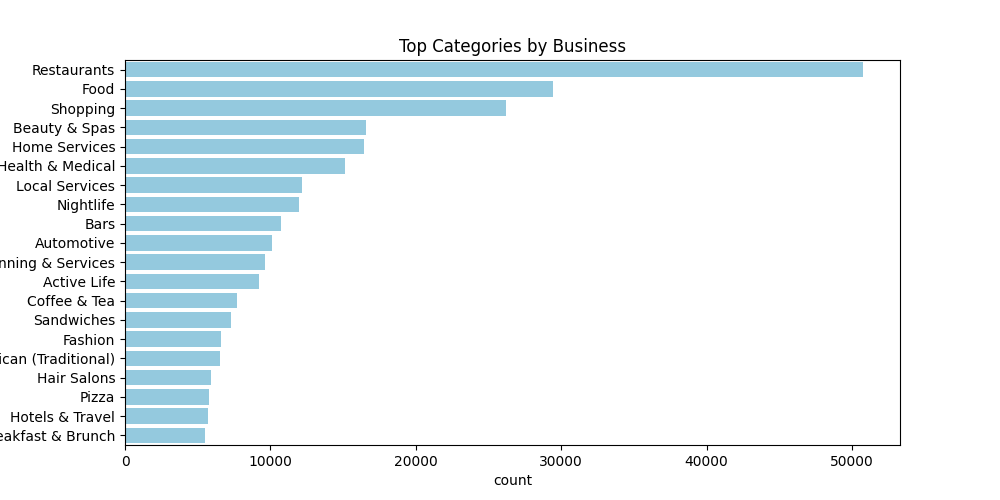

In [39]:
fig, ax = plt.subplots(figsize = (10,5))
topCat_plot = seaborn.barplot(x = 'count', y = 'category', data = topCat_pdf, ax = ax, color = 'skyblue')
ax.set_title('Top Categories by Business')
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [9]:
df2 = spark.read.json('s3://sta9760-yelp-datasets/yelp_academic_dataset_review.json')
df2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [10]:
df2.createOrReplaceTempView("stars")
output = spark.sql('select business_id, stars from stars')
output.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [23]:
meanstars = spark.sql('select business_id, avg(stars) as avgstars from stars group by business_id')
meanstars.createOrReplaceTempView("reviews")
meanstars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|         avgstars|
+--------------------+-----------------+
|wdBrDCbZopowEkIEX...|4.538461538461538|
|MPzc6QuEjwk3E3jVT...|           3.3125|
|ZhIpo-zAwcc0i9hFw...|              5.0|
|E8Fl7qE_y-bhRbkkd...|4.666666666666667|
|2boQDeHxopolPtJhV...|4.333333333333333|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [24]:
output = spark.sql(
'''
SELECT rev.*, bus.stars, bus.name, bus.city, bus.state 
                        from business as bus 
                        left join reviews as rev 
                        on bus.business_id = rev.business_id''')
output.createOrReplaceTempView("joinedOutput")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [25]:
output = spark.sql('SELECT avgstars, stars, name, city, state from joinedOutput')
output.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|          avgstars|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [26]:
skew_df = spark.sql("select (avgstars-stars)/stars as skew from joinedOutput")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

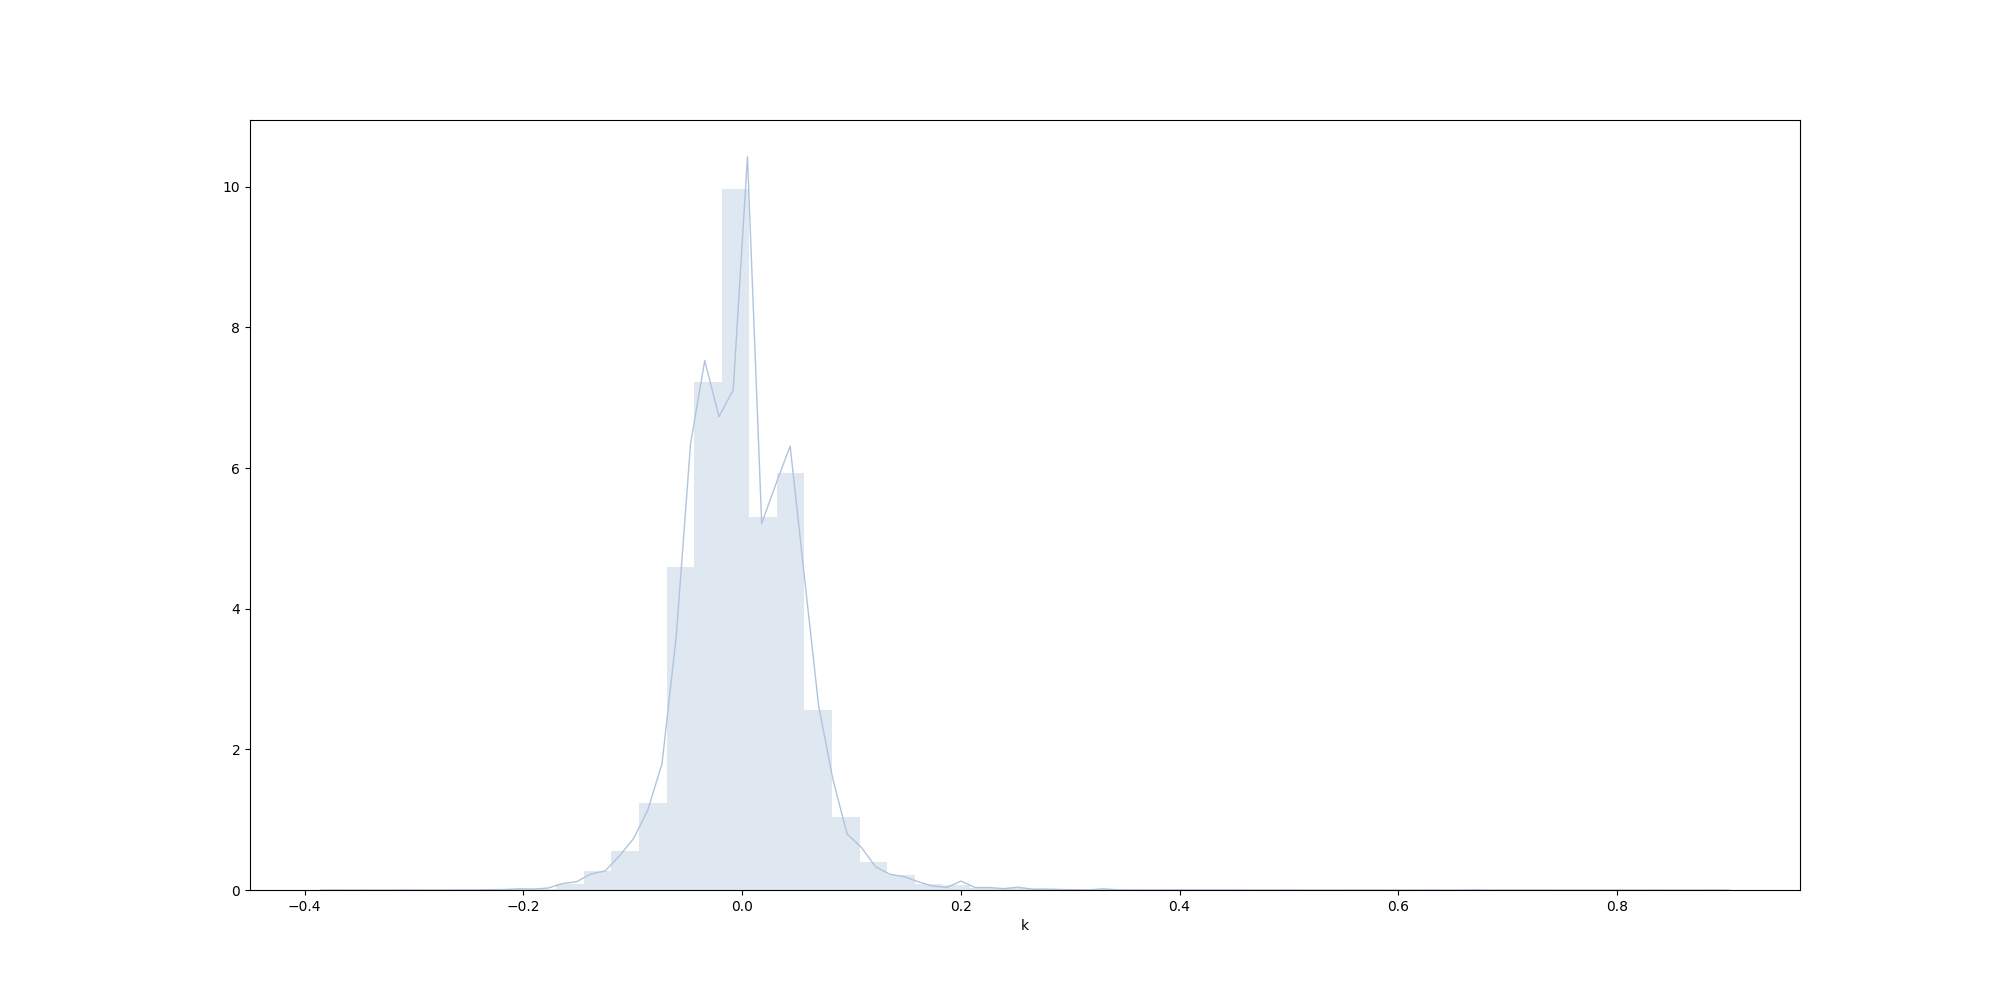

In [29]:
skew_pdf = skew_df.toPandas()

plt.figure(figsize=(20,10))
sns.distplot(skew_pdf['skew'], 
            hist=True, 
            kde=True, 
            bins=50, 
            color = 'lightsteelblue',
            kde_kws={'linewidth':1})
plt.xlabel('k')
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

Yelp (written) Reviews skew positively, which indicates that reviewers who left a written response were more dissatisfied than normal. In other words, people tend to leave negative written reviews on Yelp. Usually, users leaving reviews would complain about the service and/or give any suggestions. 

# Do users having more compliment photos tend to rate higher stars?

* Visual Connection is Key.

A picture is worth a thousand words, and even more dollars. People are more likely to order a meal in a restaurant when there is a photo of real customers. But whether business with more photos will have higher ratings. To answer this question, let's check if the users who complimenting with photos give a better stars or not.

In [4]:
df3 = spark.read.json('s3://sta9760-yelp-datasets/yelp_academic_dataset_user.json')
df3.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [7]:
df3.createOrReplaceTempView("user")
output = spark.sql('select name, user_id, compliment_photos from user')
output.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+-----------------+
|     name|             user_id|compliment_photos|
+---------+--------------------+-----------------+
|     Jane|q_QQ5kBBwlCcbL1s4...|              323|
|     Gabi|dIIKEfOgo0KqUfGQv...|              294|
|    Jason|D6ErcUnFALnCQN4b1...|                1|
|      Kat|JnPIjvC0cmooNDfsa...|              326|
|Christine|37Hc8hr3cw0iHLoPz...|               44|
+---------+--------------------+-----------------+
only showing top 5 rows

Let's join our two dataframes (users, reviews and business data) by business_id and user_id.

In [16]:
output = spark.sql(
'''
SELECT u.user_id, r.stars as user_stars, u.compliment_photos, b.business_id, b.stars as business_stars
FROM user u 
INNER JOIN stars r on r.user_id = u.user_id
INNER JOIN business b on r.business_id = b.business_id
''')
output.createOrReplaceTempView('joinedOutput1')
output = spark.sql('select * from joinedOutput1')
output.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+-----------------+--------------------+--------------+
|             user_id|user_stars|compliment_photos|         business_id|business_stars|
+--------------------+----------+-----------------+--------------------+--------------+
|--1UpCuUDJQbqiuFX...|       5.0|                0|GgR7kcKykuqXB11fW...|           4.5|
|--3Bk72HakneTyp3D...|       5.0|                0|rxNfidGLHtMYyLNeo...|           4.5|
|--3Hl2oAvTPlq-f7K...|       1.0|                0|IfOj3AxPl3Exsd_Yl...|           4.0|
|--3Hl2oAvTPlq-f7K...|       2.0|                0|2OaX6XjAoI7VD6jLd...|           4.0|
|--3Hl2oAvTPlq-f7K...|       2.0|                0|bAuYOa-VuqTOnKzWN...|           4.5|
+--------------------+----------+-----------------+--------------------+--------------+
only showing top 5 rows

In [18]:
users_photos = spark.sql('''select (user_stars-business_stars)/business_stars 
                            from joinedOutput1
                            where compliment_photos > 0''')
users_photos.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------+
|((user_stars - business_stars) / business_stars)|
+------------------------------------------------+
|                              0.3333333333333333|
|                                             0.0|
|                                             0.0|
|                                             0.0|
|                                             0.0|
|                                            0.25|
|                            -0.14285714285714285|
|                             -0.1111111111111111|
|                             0.42857142857142855|
|                            -0.42857142857142855|
|                                           -0.75|
|                                             0.0|
|                             0.42857142857142855|
|                                             0.2|
|                                             0.0|
|                                            0.25|
|                              

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

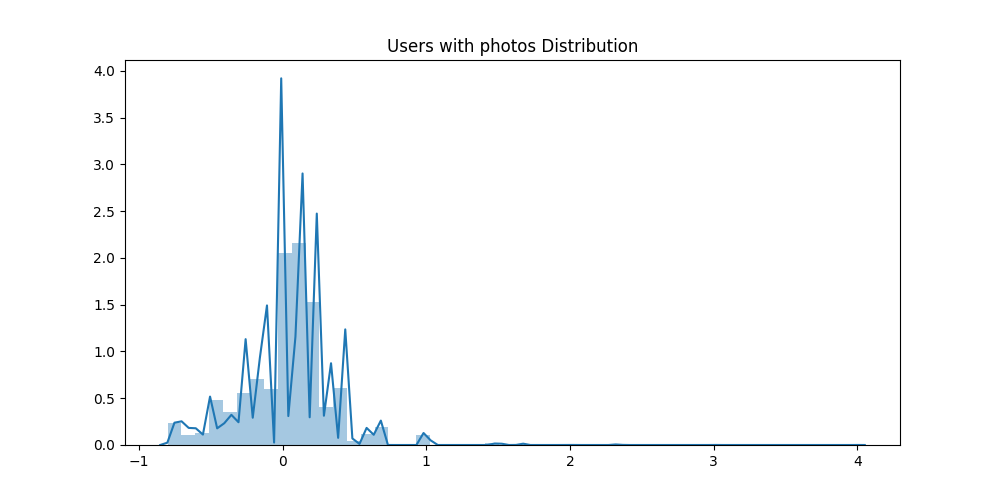

In [22]:
users_photospd = users_photos.toPandas()

fig, ax = plt.subplots(figsize = (10,5))
skew_plot = seaborn.distplot(users_photospd)
ax.set_title('Users with photos Distribution')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

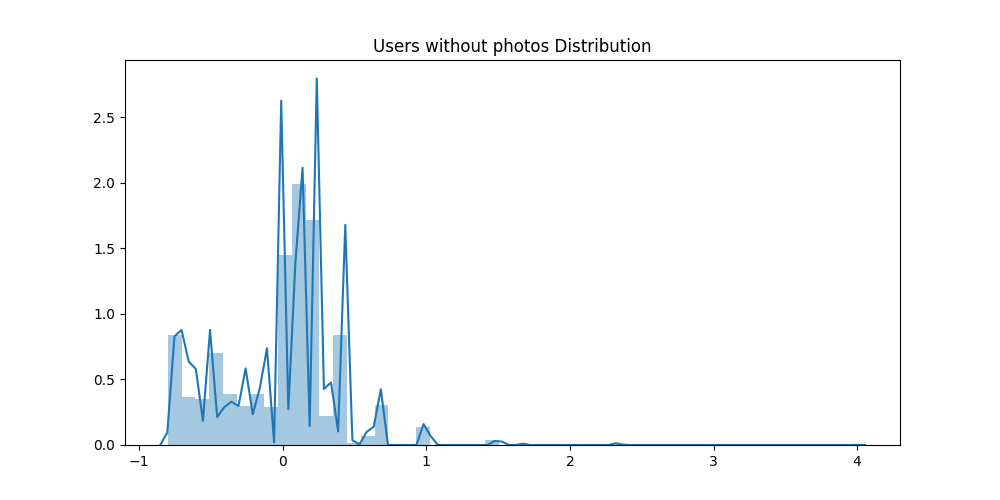

In [21]:
users_nonphotos = spark.sql('''select (user_stars-business_stars)/business_stars 
                            from joinedOutput1
                            where compliment_photos = 0''')
users_nonphotos.show()

users_nonphotospd = users_nonphotos.toPandas()

fig, ax = plt.subplots(figsize = (10,5))
skew_plot = seaborn.distplot(users_nonphotospd)
ax.set_title('Users without photos Distribution')
%matplot plt

From the graphs, we can tell that people who are complimenting with photo more likeyly to leave a better review. Users with no photo tend to have mixed reviews while giving stars to a business. What'smore, not all users with photos gave a high stars (1st plot). To improve customer service, business should look into these cases also. 